In [347]:
import psycopg2
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from kmodes.kmodes import KModes



In [348]:
conn = psycopg2.connect(database = "dsa3101", 
                        user = "postgres", 
                        host= 'localhost',
                        password = "pw", # change password
                        port = 5433) # change port if necessary

## Tables

In [349]:
# get online_sales table

cur = conn.cursor()
cur.execute('SELECT * FROM online_sales;')
rows = cur.fetchall()
column_names = [desc[0] for desc in cur.description]
online_sales = pd.DataFrame(rows, columns=column_names)
online_sales

,user_id,transaction_id,date,product_id,Quantity,Delivery_Charges,Coupon_Status,Coupon_Code,Discount_pct
0,17850,16679,2019-01-01,B09DL9978Y,1,6.50,Used,ELEC10,0.1
1,17850,16680,2019-01-01,B09DL9978Y,1,6.50,Used,ELEC10,0.1
2,17850,16681,2019-01-01,B07GXHC691,1,6.50,Used,OFF10,0.1
3,17850,16682,2019-01-01,B08NCKT9FG,5,6.50,Not Used,SALE10,0.1
4,17850,16682,2019-01-01,B08H21B6V7,1,6.50,Used,AIO10,0.1
...,...,...,...,...,...,...,...,...,...
53696,14410,48493,2019-12-31,B07XLML2YS,1,6.50,Clicked,ELEC30,0.3
53697,14410,48494,2019-12-31,B09WN3SRC7,1,6.50,Used,SALE30,0.3
53698,14410,48495,2019-12-31,B07VX71FZP,1,6.50,Used,ELEC30,0.3
53699,14600,48496,2019-12-31,B00Y4ORQ46,5,6.50,Clicked,ELEC30,0.3


In [350]:
# get products table

cur.execute('SELECT * FROM products;')
rows = cur.fetchall()
column_names = [desc[0] for desc in cur.description]
products = pd.DataFrame(rows, columns=column_names)
products

,product_id,product_name,about_product,category,actual_price,discounted_price,discount_percentage
0,B07JW9H4J1,Wayona Nylon Braided USB to Lightning Fast Cha...,High Compatibility : Compatible With iPhone 12...,Computers&Accessories|Accessories&Peripherals|...,13.19,4.79,0.64
1,B098NS6PVG,Ambrane Unbreakable 60W / 3A Fast Charging 1.5...,"Compatible with all Type C enabled devices, be...",Computers&Accessories|Accessories&Peripherals|...,4.19,2.39,0.43
2,B096MSW6CT,Sounce Fast Phone Charging Cable & Data Sync U...,【 Fast Charger& Data Sync】-With built-in safet...,Computers&Accessories|Accessories&Peripherals|...,22.79,2.39,0.90
3,B08HDJ86NZ,boAt Deuce USB 300 2 in 1 Type-C & Micro USB S...,The boAt Deuce USB 300 2 in 1 cable is compati...,Computers&Accessories|Accessories&Peripherals|...,8.39,3.95,0.53
4,B08CF3B7N1,Portronics Konnect L 1.2M Fast Charging 3A 8 P...,[CHARGE & SYNC FUNCTION]- This cable comes wit...,Computers&Accessories|Accessories&Peripherals|...,4.79,1.85,0.61
...,...,...,...,...,...,...,...
1346,B00TI8E7BI,Philips HD9306/06 1.5-Litre Electric Kettle (M...,"Food grade stainless steel, Frequency: 50 Hz. ...",Home&Kitchen|Kitchen&HomeAppliances|SmallKitch...,32.34,32.34,0.00
1347,B07J9KXQCC,"Libra Room Heater for Home, Room Heaters Home ...","Libra room heater for home has cool, warm or h...","Home&Kitchen|Heating,Cooling&AirQuality|RoomHe...",27.59,11.39,0.59
1348,B0B3JSWG81,NGI Store 2 Pieces Pet Hair Removers for Your ...,"Versatile, Protects Your Clothes: MoveCatcher ...","Home&Kitchen|Kitchen&HomeAppliances|Vacuum,Cle...",11.99,2.39,0.80
1349,B08L7J3T31,Noir Aqua - 5pcs PP Spun Filter + 1 Spanner | ...,SUPREME QUALITY 90 GRAM 3 LAYER THIK PP SPUN F...,Home&Kitchen|Kitchen&HomeAppliances|WaterPurif...,11.03,4.55,0.59


In [351]:
# get ratings table

cur.execute('SELECT * FROM ratings;')
rows = cur.fetchall()
column_names = [desc[0] for desc in cur.description]
ratings = pd.DataFrame(rows, columns=column_names)
ratings

,product_id,average_rating,review_title,review_content,rating_count
0,B002PD61Y4,4.1,"good tool to use for,Brand is always good,Over...",good quality tool from d linkWiFi signal is go...,16262
1,B002SZEOLG,4.2,Works on linux for me. Get the model with ante...,I use this to connect an old PC to internet. I...,179692
2,B003B00484,4.3,"Works Good,Perfect replacement cell for trimme...","Works good,Bought it to replace my Phillips QT...",27201
3,B003L62T7W,4.3,"Handy Mouse,Good quality mouse,Good one.,Good,...","Liked this Product,https://m.media-amazon.com/...",31534
4,B004IO5BMQ,4.5,"Good silent mouse,Too small to hold!,Reviewing...",It's little small for big hands. But best avai...,54405
...,...,...,...,...,...
1346,B0BPCJM7TB,4.0,"Nice frother,Nice product I like this product,...",This is my first coffee frother and I just lov...,43
1347,B0BPJBTB3F,2.0,"Bad quality,Amazing product..",The heating capacity is zero .Moreover i have ...,2
1348,B0BQ3K23Y1,4.8,"Oratech Best Coffee Frother,Great,My review ab...","Overall, I love this Oratech Coffee frother an...",28
1349,B0BQRJ3C47,5.0,Awesome Product,Quick delivery.Awesome ProductPacking was good...,0


In [352]:
# get user_behaviour table

cur.execute('SELECT * FROM user_behaviour;')
rows = cur.fetchall()
column_names = [desc[0] for desc in cur.description]
user_behaviour = pd.DataFrame(rows, columns=column_names)
user_behaviour

,user_id,timestamp,purchase_Frequency,purchase_Categories,personalized_Recommendation_Success,browsing_Frequency,product_Search_Method,search_Result_Exploration,customer_Reviews_Importance,add_to_Cart_Browsing,...,saveforlater_Frequency,review_Left,review_Reliability,review_Helpfulness,recommendation_Helpfulness,personalized_Recommendation_Frequency,rating_Accuracy,shopping_Satisfaction,service_Appreciation,improvement_Areas
0,1,2023-06-04 13:28:19,Few times a month,Beauty and Personal Care,Yes,Few times a week,Keyword,Multiple pages,1,Yes,...,Sometimes,Yes,Occasionally,Yes,Yes,2,1,1,Competitive prices,Reducing packaging waste
1,2,2023-06-04 14:30:44,Once a month,Clothing and Fashion,Yes,Few times a month,Keyword,Multiple pages,1,Yes,...,Rarely,No,Heavily,Yes,Sometimes,2,3,2,Wide product selection,Reducing packaging waste
2,3,2023-06-04 17:04:56,Few times a month,Groceries and Gourmet Food;Clothing and Fashion,No,Few times a month,Keyword,Multiple pages,2,Yes,...,Rarely,No,Occasionally,No,No,4,3,3,Competitive prices,Product quality and accuracy
3,4,2023-06-04 17:13:00,Once a month,Beauty and Personal Care;Clothing and Fashion;...,Sometimes,Few times a month,Keyword,First page,5,Maybe,...,Sometimes,Yes,Heavily,Yes,Sometimes,3,3,4,Competitive prices,Product quality and accuracy
4,5,2023-06-04 17:28:06,Less than once a month,Beauty and Personal Care;Clothing and Fashion,Yes,Few times a month,Filter,Multiple pages,1,Yes,...,Rarely,No,Heavily,Yes,Yes,4,2,2,Competitive prices,Product quality and accuracy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
597,598,2023-06-12 16:02:02,Once a week,Beauty and Personal Care,Sometimes,Few times a week,categories,Multiple pages,4,Maybe,...,Sometimes,Yes,Moderately,Sometimes,Sometimes,3,3,4,Competitive prices,Customer service responsiveness
598,599,2023-06-12 16:02:53,Once a week,Clothing and Fashion,Sometimes,Few times a week,Filter,Multiple pages,3,Maybe,...,Sometimes,Yes,Heavily,Sometimes,Sometimes,3,3,3,Product recommendations,Reducing packaging waste
599,600,2023-06-12 16:03:59,Once a month,Beauty and Personal Care,Sometimes,Few times a week,categories,Multiple pages,3,Maybe,...,Sometimes,Yes,Occasionally,Sometimes,Sometimes,3,2,3,Wide product selection,Product quality and accuracy
600,601,2023-06-12 21:57:20,Few times a month,Beauty and Personal Care;Clothing and Fashion;...,Yes,Few times a month,Keyword,Multiple pages,1,Yes,...,Sometimes,No,Heavily,Yes,Yes,2,2,2,Wide product selection,Product quality and accuracy


In [353]:
# get users table

cur.execute('SELECT * FROM users;')
rows = cur.fetchall()
column_names = [desc[0] for desc in cur.description]
users = pd.DataFrame(rows, columns=column_names)
users

,user_id,age,gender
0,1,23,Female
1,2,23,Female
2,3,24,Prefer not to say
3,4,24,Female
4,5,22,Female
...,...,...,...
2065,14438,57,Female
2066,12956,60,Female
2067,15781,55,Male
2068,14410,19,Female


## Part 1: Analyze historical sales data

### EDA

In [354]:
online_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53701 entries, 0 to 53700
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   user_id           53701 non-null  int64         
 1   transaction_id    53701 non-null  int64         
 2   date              53701 non-null  datetime64[ns]
 3   product_id        53701 non-null  object        
 4   Quantity          53701 non-null  int64         
 5   Delivery_Charges  53701 non-null  float64       
 6   Coupon_Status     53701 non-null  object        
 7   Coupon_Code       53701 non-null  object        
 8   Discount_pct      53701 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(3), object(3)
memory usage: 3.7+ MB


In [355]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1351 entries, 0 to 1350
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   product_id           1351 non-null   object
 1   product_name         1351 non-null   object
 2   about_product        1351 non-null   object
 3   category             1351 non-null   object
 4   actual_price         1351 non-null   object
 5   discounted_price     1351 non-null   object
 6   discount_percentage  1351 non-null   object
dtypes: object(7)
memory usage: 74.0+ KB


In [356]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1351 entries, 0 to 1350
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   product_id      1351 non-null   object 
 1   average_rating  1351 non-null   float64
 2   review_title    1351 non-null   object 
 3   review_content  1351 non-null   object 
 4   rating_count    1351 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 52.9+ KB


In [357]:
# Join online_sales, users, products and ratings tables
historical_sales = online_sales.copy()
historical_sales = pd.merge(historical_sales, users, on='user_id', how='inner')
historical_sales = pd.merge(historical_sales, products, on='product_id', how='inner')
historical_sales = pd.merge(historical_sales, ratings, on='product_id', how='inner')
historical_sales.head()

,user_id,transaction_id,date,product_id,Quantity,Delivery_Charges,Coupon_Status,Coupon_Code,Discount_pct,age,...,product_name,about_product,category,actual_price,discounted_price,discount_percentage,average_rating,review_title,review_content,rating_count
0,17850,16679,2019-01-01,B09DL9978Y,1,6.5,Used,ELEC10,0.1,33,...,Hindware Atlantic Compacto 3 Litre Instant wat...,Stainless Steel Tank|Copper Heating element|IS...,"Home&Kitchen|Heating,Cooling&AirQuality|WaterH...",55.08,28.79,0.48,4.1,"Good heater, and delivery and installation was...",The instant heater was well made. And works we...,444
1,17850,16680,2019-01-01,B09DL9978Y,1,6.5,Used,ELEC10,0.1,33,...,Hindware Atlantic Compacto 3 Litre Instant wat...,Stainless Steel Tank|Copper Heating element|IS...,"Home&Kitchen|Heating,Cooling&AirQuality|WaterH...",55.08,28.79,0.48,4.1,"Good heater, and delivery and installation was...",The instant heater was well made. And works we...,444
2,17850,16681,2019-01-01,B07GXHC691,1,6.5,Used,OFF10,0.1,33,...,STRIFF PS2_01 Multi Angle Mobile/Tablet Tablet...,"[PORTABLE SIZE]- 98mm*96mm*19mm, STRIFF desk p...",Electronics|Mobiles&Accessories|MobileAccessor...,5.99,1.19,0.80,4.3,"Good Stand For Mobiles !,Nice produt,Useful,Af...",This is good mobile stand. Sturdy with mobiles...,42641
3,17850,16682,2019-01-01,B08NCKT9FG,5,6.5,Not Used,SALE10,0.1,33,...,Boat A 350 Type C Cable 1.5m(Jet Black),"2 years warranty from the date of purchase, yo...",Computers&Accessories|Accessories&Peripherals|...,9.58,3.59,0.63,4.4,"Good Stuff... Recommended!!!,Need better quali...","Good Stuff... Recommended!!!,Need better quali...",28791
4,17850,16682,2019-01-01,B08H21B6V7,1,6.5,Used,AIO10,0.1,33,...,Nokia 150 (2020) (Cyan),MicroSD card slot expandable up to 32. Network...,Electronics|Mobiles&Accessories|Smartphones&Ba...,35.99,31.19,0.13,3.9,"Ok phone,Good Basic Phone,Nice one,Hghjk,Good ...",Audio contains lots of distortion when using s...,14266


In [358]:
historical_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53701 entries, 0 to 53700
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              53701 non-null  int64         
 1   transaction_id       53701 non-null  int64         
 2   date                 53701 non-null  datetime64[ns]
 3   product_id           53701 non-null  object        
 4   Quantity             53701 non-null  int64         
 5   Delivery_Charges     53701 non-null  float64       
 6   Coupon_Status        53701 non-null  object        
 7   Coupon_Code          53701 non-null  object        
 8   Discount_pct         53701 non-null  float64       
 9   age                  53701 non-null  int64         
 10  gender               53701 non-null  object        
 11  product_name         53701 non-null  object        
 12  about_product        53701 non-null  object        
 13  category             53701 non-

In [359]:
historical_sales['Coupon_Status'].value_counts()

Coupon_Status
Clicked     27306
Used        18180
Not Used     8215
Name: count, dtype: int64

Create a total_price column where total_price = discounted_price x quantity if the Coupon_Status was used, and total_price = actual_price x quantity otherwise. In this case, a Clicked Coupon_Status means that a customer tried to use the coupon but it was not applicable to the product.

In [360]:
historical_sales['total_price'] = np.where(
    historical_sales['Coupon_Status'] == 'Used',
    historical_sales['Quantity'] * historical_sales['discounted_price'],
    historical_sales['Quantity'] * historical_sales['actual_price']
)
historical_sales.head()

,user_id,transaction_id,date,product_id,Quantity,Delivery_Charges,Coupon_Status,Coupon_Code,Discount_pct,age,...,about_product,category,actual_price,discounted_price,discount_percentage,average_rating,review_title,review_content,rating_count,total_price
0,17850,16679,2019-01-01,B09DL9978Y,1,6.5,Used,ELEC10,0.1,33,...,Stainless Steel Tank|Copper Heating element|IS...,"Home&Kitchen|Heating,Cooling&AirQuality|WaterH...",55.08,28.79,0.48,4.1,"Good heater, and delivery and installation was...",The instant heater was well made. And works we...,444,28.79
1,17850,16680,2019-01-01,B09DL9978Y,1,6.5,Used,ELEC10,0.1,33,...,Stainless Steel Tank|Copper Heating element|IS...,"Home&Kitchen|Heating,Cooling&AirQuality|WaterH...",55.08,28.79,0.48,4.1,"Good heater, and delivery and installation was...",The instant heater was well made. And works we...,444,28.79
2,17850,16681,2019-01-01,B07GXHC691,1,6.5,Used,OFF10,0.1,33,...,"[PORTABLE SIZE]- 98mm*96mm*19mm, STRIFF desk p...",Electronics|Mobiles&Accessories|MobileAccessor...,5.99,1.19,0.80,4.3,"Good Stand For Mobiles !,Nice produt,Useful,Af...",This is good mobile stand. Sturdy with mobiles...,42641,1.19
3,17850,16682,2019-01-01,B08NCKT9FG,5,6.5,Not Used,SALE10,0.1,33,...,"2 years warranty from the date of purchase, yo...",Computers&Accessories|Accessories&Peripherals|...,9.58,3.59,0.63,4.4,"Good Stuff... Recommended!!!,Need better quali...","Good Stuff... Recommended!!!,Need better quali...",28791,47.90
4,17850,16682,2019-01-01,B08H21B6V7,1,6.5,Used,AIO10,0.1,33,...,MicroSD card slot expandable up to 32. Network...,Electronics|Mobiles&Accessories|Smartphones&Ba...,35.99,31.19,0.13,3.9,"Ok phone,Good Basic Phone,Nice one,Hghjk,Good ...",Audio contains lots of distortion when using s...,14266,31.19


In [361]:
# Aggregate by day
daily_sales = historical_sales.groupby(historical_sales['date'].dt.date).agg(total_sales=('total_price', 'sum')).reset_index()

# Aggregate by month
monthly_sales = historical_sales.groupby(historical_sales['date'].dt.to_period('M')).agg(total_sales=('total_price', 'sum')).reset_index()
monthly_sales['date'] = monthly_sales['date'].dt.to_timestamp()
monthly_sales

,date,total_sales
0,2019-01-01,1851069.52
1,2019-02-01,1984696.82
2,2019-03-01,2540665.21
3,2019-04-01,2475494.46
4,2019-05-01,2185261.49
5,2019-06-01,2016902.84
6,2019-07-01,3257269.37
7,2019-08-01,2854352.38
8,2019-09-01,2823836.49
9,2019-10-01,2252121.56


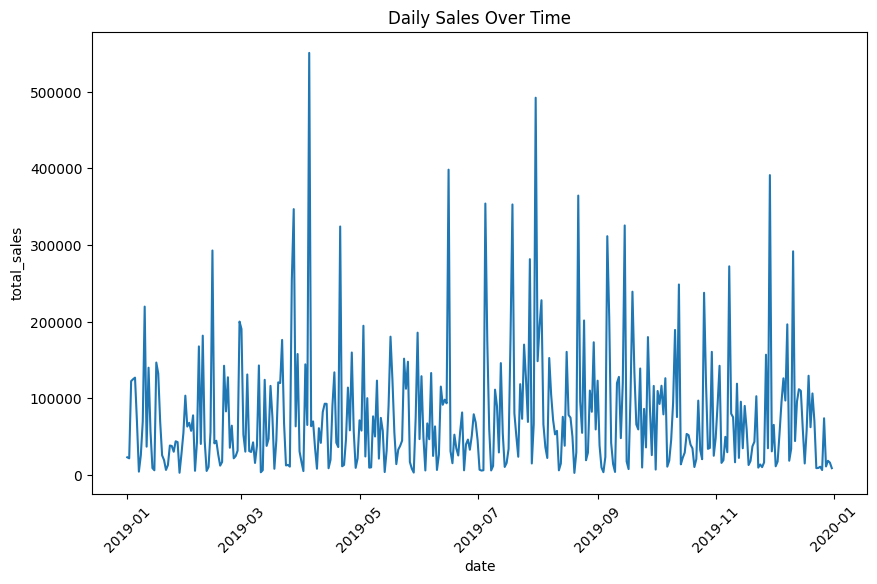

In [362]:
# Plot daily sales
plt.figure(figsize=(10,6))
sns.lineplot(x='date', y='total_sales', data=daily_sales)
plt.title('Daily Sales Over Time')
plt.xticks(rotation=45)
plt.show()

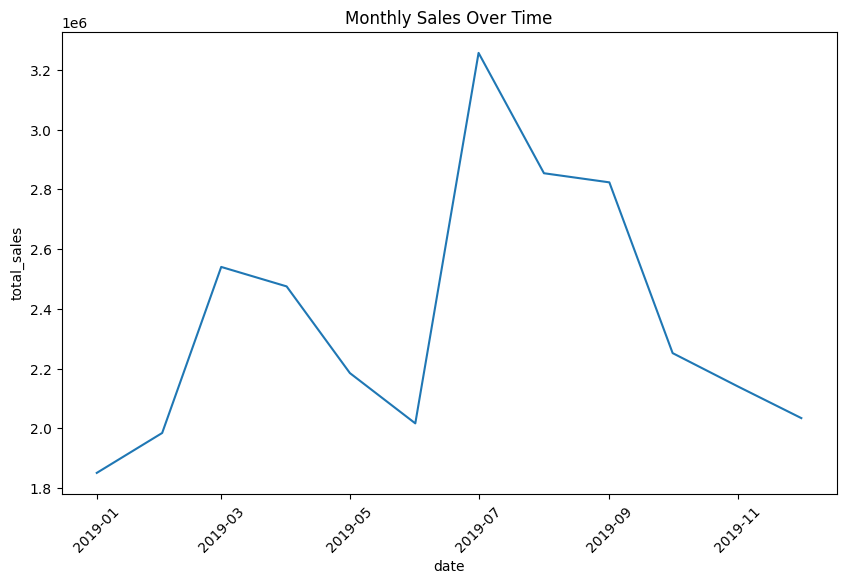

In [363]:
# Plot monthly sales
plt.figure(figsize=(10,6))
sns.lineplot(x='date', y='total_sales', data=monthly_sales)
plt.title('Monthly Sales Over Time')
plt.xticks(rotation=45)
plt.show()

There is a peak in total sales in the July which decreases towards the end of the year. However, it is hard to determine if this is a pattern as we only have one year's worth of data.

In [364]:
# Total sales by product
top_products = historical_sales.groupby('product_name').agg(total_sales=('total_price', 'sum')).reset_index()

# Sort by total sales
top_products = top_products.sort_values(by='total_sales', ascending=False).head(10)


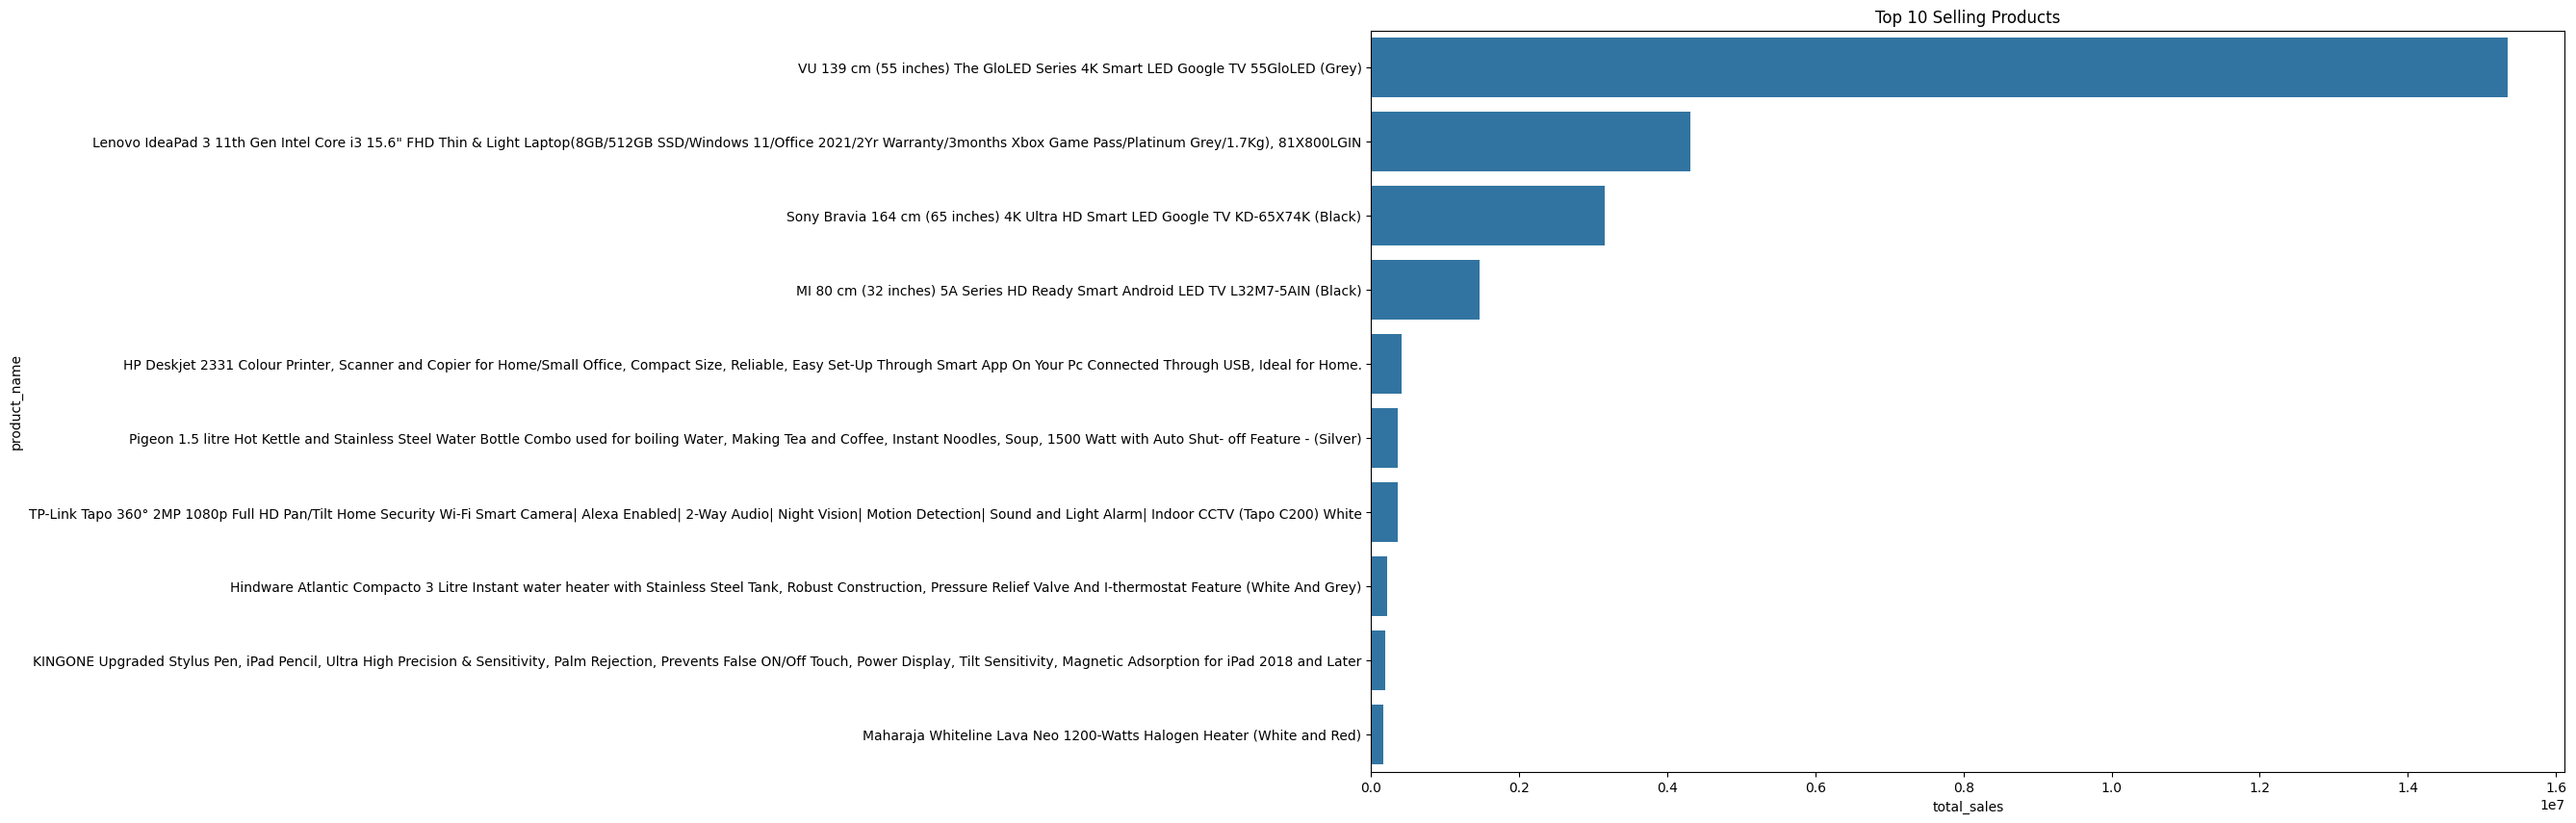

In [365]:
# Bar plot of top 10 products
plt.figure(figsize=(16,10))
sns.barplot(x='total_sales', y='product_name', data=top_products)
plt.title('Top 10 Selling Products')
plt.show()


/var/folders/gd/v8v96pt94wl6b52w5qldf23m0000gn/T/ipykernel_28868/2578179954.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_group_sales = historical_sales.groupby('age_group').agg(total_sales=('total_price', 'sum')).reset_index()


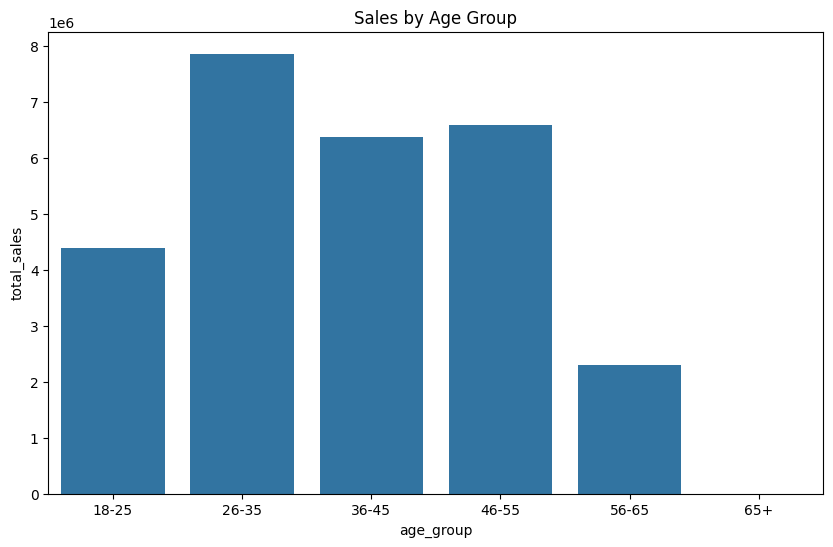

In [366]:
# Creating age bins
bins = [18, 25, 35, 45, 55, 65, 100]
labels = ['18-25', '26-35', '36-45', '46-55', '56-65', '65+']
historical_sales['age_group'] = pd.cut(historical_sales['age'], bins=bins, labels=labels)

# Aggregate sales by age group
age_group_sales = historical_sales.groupby('age_group').agg(total_sales=('total_price', 'sum')).reset_index()

# Bar plot of sales by age group
plt.figure(figsize=(10,6))
sns.barplot(x='age_group', y='total_sales', data=age_group_sales)
plt.title('Sales by Age Group')
plt.show()


People aged 26-35 spend the most online.

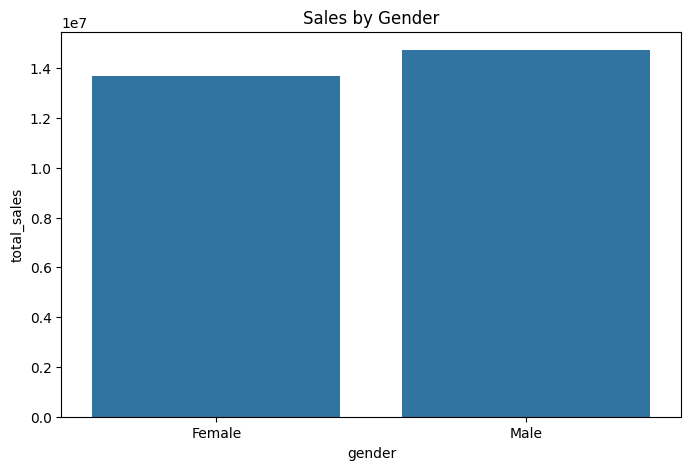

In [367]:
# Aggregate sales by gender
gender_sales = historical_sales.groupby('gender').agg(total_sales=('total_price', 'sum')).reset_index()

# Bar plot of sales by gender
plt.figure(figsize=(8,5))
sns.barplot(x='gender', y='total_sales', data=gender_sales)
plt.title('Sales by Gender')
plt.show()


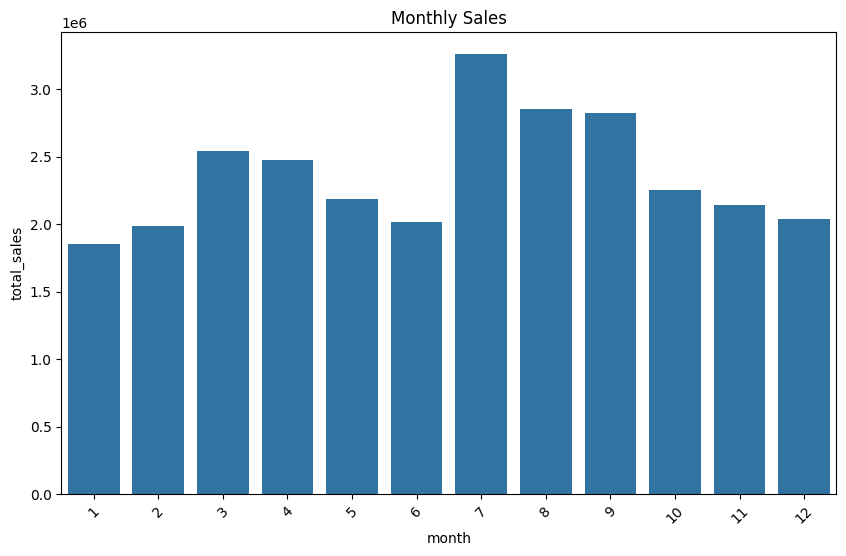

In [368]:
# Group by month (without year)
historical_sales['month'] = historical_sales['date'].dt.month
monthly_sales = historical_sales.groupby('month').agg(total_sales=('total_price', 'sum')).reset_index()

# Plot sales by month
plt.figure(figsize=(10,6))
sns.barplot(x='month', y='total_sales', data=monthly_sales)
plt.title('Monthly Sales')
plt.xticks(rotation=45)
plt.show()


customer_type
repeat      1423
one-time      45
Name: count, dtype: int64


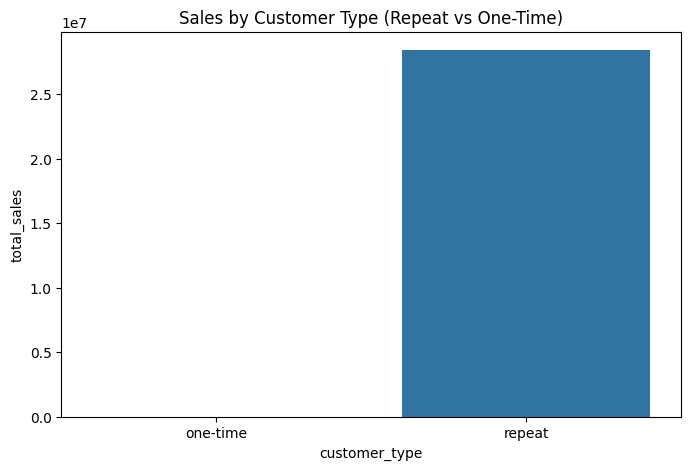

In [369]:
# Count the number of purchases per customer
repeat_customers = historical_sales.groupby('user_id').agg(num_purchases=('Quantity', 'sum')).reset_index()

# Classify customers as 'repeat' or 'one-time'
repeat_customers['customer_type'] = repeat_customers['num_purchases'].apply(lambda x: 'repeat' if x > 1 else 'one-time')

# Aggregate sales by customer type
customer_type_sales = pd.merge(historical_sales, repeat_customers[['user_id', 'customer_type']], on='user_id')
customer_type_sales = customer_type_sales.groupby('customer_type').agg(total_sales=('total_price', 'sum')).reset_index()
print(repeat_customers['customer_type'].value_counts())

# Plot sales by customer type
plt.figure(figsize=(8,5))
sns.barplot(x='customer_type', y='total_sales', data=customer_type_sales)
plt.title('Sales by Customer Type (Repeat vs One-Time)')
plt.show()


Most shoppers are repeat customers and the total sales generated by them is about 2 million USD.

In [370]:
# convert necessary columns to float64
historical_sales['actual_price'] = pd.to_numeric(historical_sales['actual_price'], errors='coerce')
historical_sales['discounted_price'] = pd.to_numeric(historical_sales['discounted_price'], errors='coerce')
historical_sales['discount_percentage'] = pd.to_numeric(historical_sales['discount_percentage'], errors='coerce')
historical_sales['total_price'] = pd.to_numeric(historical_sales['total_price'], errors='coerce')
historical_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53701 entries, 0 to 53700
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              53701 non-null  int64         
 1   transaction_id       53701 non-null  int64         
 2   date                 53701 non-null  datetime64[ns]
 3   product_id           53701 non-null  object        
 4   Quantity             53701 non-null  int64         
 5   Delivery_Charges     53701 non-null  float64       
 6   Coupon_Status        53701 non-null  object        
 7   Coupon_Code          53701 non-null  object        
 8   Discount_pct         53701 non-null  float64       
 9   age                  53701 non-null  int64         
 10  gender               53701 non-null  object        
 11  product_name         53701 non-null  object        
 12  about_product        53701 non-null  object        
 13  category             53701 non-

In [371]:
encoded_sales = historical_sales.drop(columns=['user_id', 'transaction_id', 'date', 'product_id', 
                              'Coupon_Code', 'product_name', 'about_product', 'review_title',
                              'review_content', 'month', 'age_group', 'actual_price', 'discounted_price'])
encoded_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53701 entries, 0 to 53700
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Quantity             53701 non-null  int64  
 1   Delivery_Charges     53701 non-null  float64
 2   Coupon_Status        53701 non-null  object 
 3   Discount_pct         53701 non-null  float64
 4   age                  53701 non-null  int64  
 5   gender               53701 non-null  object 
 6   category             53701 non-null  object 
 7   discount_percentage  53701 non-null  float64
 8   average_rating       53701 non-null  float64
 9   rating_count         53701 non-null  int64  
 10  total_price          53701 non-null  float64
dtypes: float64(5), int64(3), object(3)
memory usage: 4.5+ MB


In [372]:
cols = encoded_sales.select_dtypes(include='object').columns
le=LabelEncoder()

for i in cols:
  encoded_sales[i]=le.fit_transform(encoded_sales[i])

encoded_sales.head()

,Quantity,Delivery_Charges,Coupon_Status,Discount_pct,age,gender,category,discount_percentage,average_rating,rating_count,total_price
0,1,6.5,2,0.1,33,0,46,0.48,4.1,444,28.79
1,1,6.5,2,0.1,33,0,46,0.48,4.1,444,28.79
2,1,6.5,2,0.1,33,0,29,0.80,4.3,42641,1.19
3,5,6.5,1,0.1,33,0,0,0.63,4.4,28791,47.90
4,1,6.5,2,0.1,33,0,31,0.13,3.9,14266,31.19


Correlation Matrix 

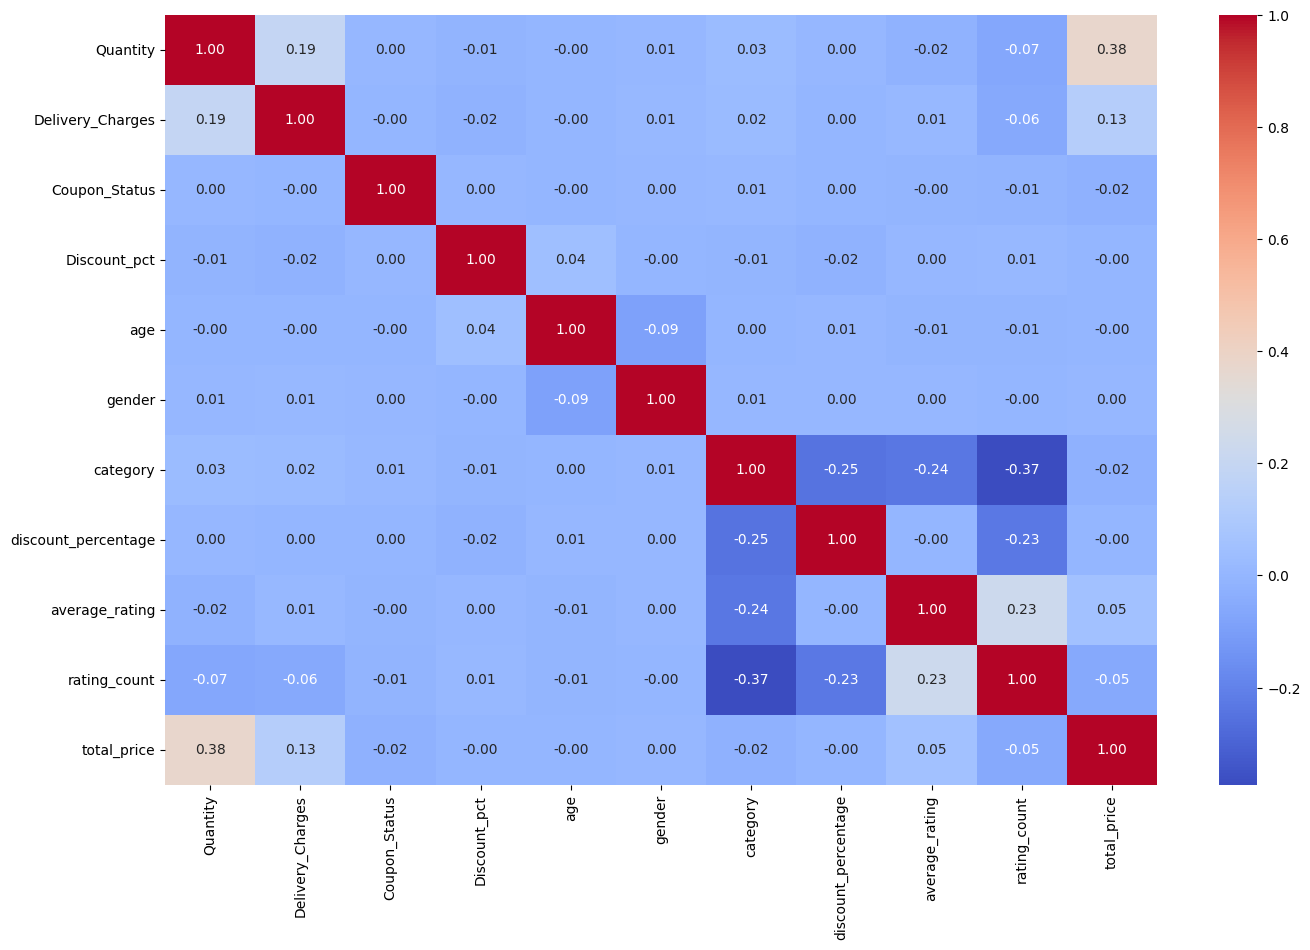

In [373]:
correlation_matrix = encoded_sales.corr()
plt.figure(figsize=(16, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

None of the features are highly correlated.

## Part 2: Analyse purchasing behaviour

RFM (Recency, Frequency, Monetary) Analysis

In [374]:
# total_price to float
historical_sales['total_price'] = historical_sales['total_price'].astype(float)

# Set a reference date for recency calculations (e.g., today’s date)
reference_date = pd.to_datetime('2024-10-05')

# Aggregate data by customer (user_id)
rfm = historical_sales.groupby('user_id').agg({
    'date': lambda x: (reference_date - x.max()).days,  # Recency
    'transaction_id': 'count',                         # Frequency
    'total_price': 'sum'                               # Monetary
})

rfm.columns = ['Recency', 'Frequency', 'Monetary']

# Rank each customer for Recency, Frequency, and Monetary
rfm['Recency_rank'] = pd.qcut(rfm['Recency'], 5, labels=[5, 4, 3, 2, 1])
rfm['Frequency_rank'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5])
rfm['Monetary_rank'] = pd.qcut(rfm['Monetary'].astype(float), 5, labels=[1, 2, 3, 4, 5])  # Ensuring Monetary is float

# Combine RFM scores
rfm['RFM_Score'] = rfm['Recency_rank'].astype(int) + rfm['Frequency_rank'].astype(int) + rfm['Monetary_rank'].astype(int)

# Customer segmentation based on RFM score
rfm['Segment'] = pd.cut(rfm['RFM_Score'], bins=[2, 5, 8, 11, 15], labels=['Low', 'Medium', 'High', 'Top'])

# Display the RFM table with segments
rfm.head()


,Recency,Frequency,Monetary,Recency_rank,Frequency_rank,Monetary_rank,RFM_Score,Segment
user_id,,,,,,,,
12346,1847,2,1061.91,3,1,2,6,Medium
12347,1799,60,11930.48,4,5,4,13,Top
12348,1813,23,28164.13,4,3,5,12,Top
12350,1757,17,11875.48,5,3,4,12,Top
12356,1847,36,6234.14,3,4,3,10,High


Each customer was assigned a rank based from 1 - 5 for Recency, Frequency and Monetary based on their last purchase, total number of purchases and total amount spent respectively. 
Their total of their ranks will result in their RFM score.
The RFM scores were split into Low (2-5), Medium (6-8), High (9-11) and Top (12-15).
This means customers with higher RFM scores, who are frequent buyers, have high spending, and recently made purchases, will fall into the Top segment, while those with lower RFM scores, reflecting infrequent, low-value purchases or long inactivity, will fall into the Low segment.

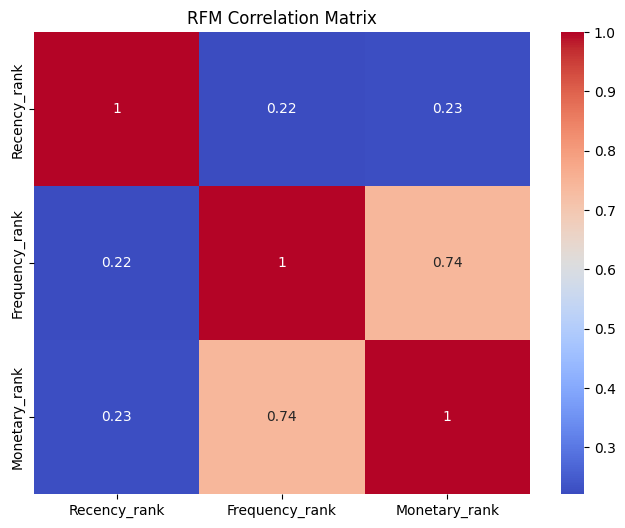

In [375]:
rfm_corr = rfm[['Recency_rank', 'Frequency_rank', 'Monetary_rank']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(rfm_corr, annot=True, cmap='coolwarm')
plt.title('RFM Correlation Matrix')
plt.show()


We see that Frequency and Monetary has a relatively strong positive correlation of 0.74. This implies that customers who make purchases more frequently also tend to spend more money (higher monetary value) and could mean that customers with frequent purchases are likely higher-value customers, making them important for retention efforts.

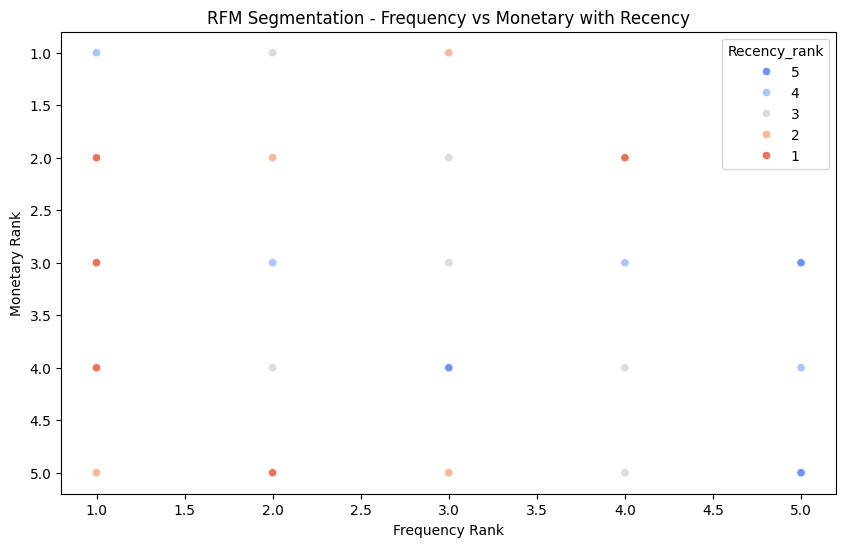

In [376]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Frequency_rank', y='Monetary_rank', hue='Recency_rank', data=rfm, palette='coolwarm')
plt.title('RFM Segmentation - Frequency vs Monetary with Recency')
plt.xlabel('Frequency Rank')
plt.ylabel('Monetary Rank')
plt.show()


There is a general trend where customers have a higher recency rank as their frequency and monetary rank increases.

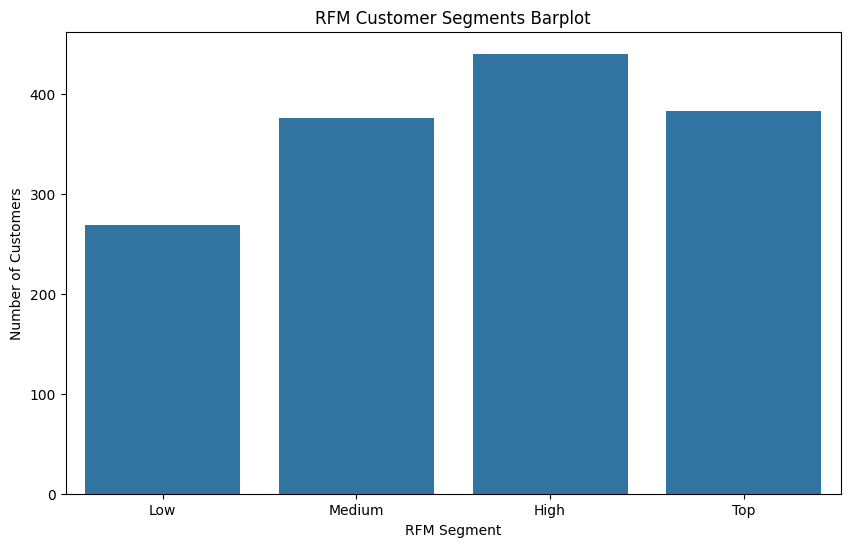

In [377]:
# rfm['RFM_Segment'] = rfm['Recency_rank'].astype(str) + rfm['Frequency_rank'].astype(str) + rfm['Monetary_rank'].astype(str)

rfm_segment_counts = rfm['Segment'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=rfm_segment_counts.index, y=rfm_segment_counts.values)
plt.title('RFM Customer Segments Barplot')
plt.xlabel('RFM Segment')
plt.ylabel('Number of Customers')
plt.show()


We see that most of the customers fall under the High and Top segments. Considering that these customers likely drive a significant portion of revenue, it would be wise to focus on maintaining engagement and offering exclusive deals or loyalty programs to sustain their high purchase rates.


CLTV Prediction Model

/var/folders/gd/v8v96pt94wl6b52w5qldf23m0000gn/T/ipykernel_28868/498327307.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  customer_data['recency'].fillna(customer_data['recency'].max(), inplace=True)
/var/folders/gd/v8v96pt94wl6b52w5qldf23m0000gn/T/ipykernel_28868/498327307.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on whi

Mean Squared Error: 91535436.98252478
R-squared: 0.9236561142627403


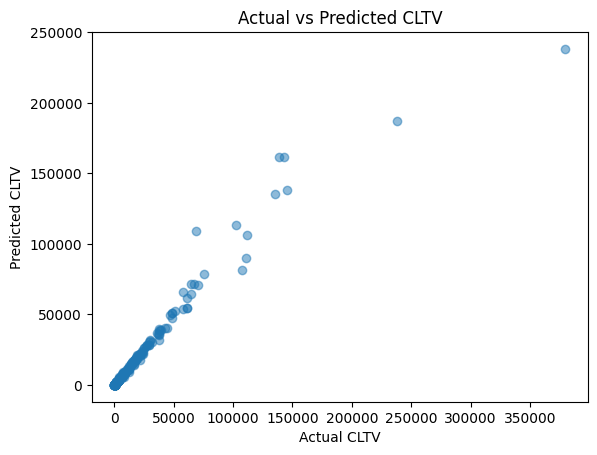

In [378]:
# Aggregate data at the customer level
customer_data = historical_sales.groupby('user_id').agg({
    'transaction_id': 'count',           # Number of orders (Frequency)
    'total_price': 'sum',                  # Total revenue (Monetary)
    'date': ['min', 'max'],                # Recency
    'product_id': 'nunique',               # Number of unique products purchased
}).reset_index()

customer_data.columns = ['user_id', 'total_orders', 'total_revenue', 'first_purchase', 'last_purchase', 'unique_products']

# Calculate recency as the difference between the last purchase and a reference date (latest purchase date)
reference_date = historical_sales['date'].max()
customer_data['recency'] = (reference_date - customer_data['last_purchase']).dt.days

# Calculate average order value (AOV)
customer_data['AOV'] = customer_data['total_revenue'] / customer_data['total_orders']

# Calculate frequency (orders per day)
customer_data['purchase_days'] = (customer_data['last_purchase'] - customer_data['first_purchase']).dt.days + 1
customer_data['frequency'] = customer_data['total_orders'] / customer_data['purchase_days']

# Fill missing values (e.g., for customers with only one order)
customer_data['recency'].fillna(customer_data['recency'].max(), inplace=True)
customer_data['frequency'].fillna(0, inplace=True)

# Assume future CLTV is proportional to total_revenue in historical data 
customer_data['CLTV'] = customer_data['total_revenue']  

features = ['recency', 'total_orders', 'AOV', 'frequency', 'unique_products']
X = customer_data[features]
y = customer_data['CLTV']

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Training using Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

# Visualize predicted vs actual CLTV
import matplotlib.pyplot as plt
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual CLTV')
plt.ylabel('Predicted CLTV')
plt.title('Actual vs Predicted CLTV')
plt.show()


In [379]:
# Aggregate data at the customer level
customer_data = historical_sales.groupby('user_id').agg({
    'transaction_id': 'count',           # Number of orders (Frequency)
    'total_price': 'sum',                  # Total revenue (Monetary)
    'date': ['min', 'max'],                # Recency
    'product_id': 'nunique',               # Number of unique products purchased
}).reset_index()

customer_data.columns = ['user_id', 'total_orders', 'total_revenue', 'first_purchase', 'last_purchase', 'unique_products']
customer_data.head()

,user_id,total_orders,total_revenue,first_purchase,last_purchase,unique_products
0,12346,2,1061.91,2019-09-15,2019-09-15,2
1,12347,60,11930.48,2019-03-24,2019-11-02,33
2,12348,23,28164.13,2019-06-22,2019-10-19,16
3,12350,17,11875.48,2019-12-14,2019-12-14,7
4,12356,36,6234.14,2019-09-15,2019-09-15,25


In [380]:
# Calculate recency as the difference between the last purchase and a reference date (latest purchase date)
reference_date = historical_sales['date'].max()
customer_data['recency'] = (reference_date - customer_data['last_purchase']).dt.days

In [381]:
# Calculate average order value (AOV)
customer_data['AOV'] = customer_data['total_revenue'] / customer_data['total_orders']

In [382]:
# Calculate frequency (orders per day)
customer_data['purchase_days'] = (customer_data['last_purchase'] - customer_data['first_purchase']).dt.days + 1
customer_data['frequency'] = customer_data['total_orders'] / customer_data['purchase_days']

In [383]:
customer_data['CLTV'] = customer_data['total_revenue']  # Placeholder for now

features = ['recency', 'total_orders', 'AOV', 'frequency', 'unique_products']
X = customer_data[features]
y = customer_data['CLTV']
customer_data

,user_id,total_orders,total_revenue,first_purchase,last_purchase,unique_products,recency,AOV,purchase_days,frequency,CLTV
0,12346,2,1061.91,2019-09-15,2019-09-15,2,107,530.955000,1,2.000000,1061.91
1,12347,60,11930.48,2019-03-24,2019-11-02,33,59,198.841333,224,0.267857,11930.48
2,12348,23,28164.13,2019-06-22,2019-10-19,16,73,1224.527391,120,0.191667,28164.13
3,12350,17,11875.48,2019-12-14,2019-12-14,7,17,698.557647,1,17.000000,11875.48
4,12356,36,6234.14,2019-09-15,2019-09-15,25,107,173.170556,1,36.000000,6234.14
...,...,...,...,...,...,...,...,...,...,...,...
1463,18259,7,2198.25,2019-04-05,2019-04-05,4,270,314.035714,1,7.000000,2198.25
1464,18260,40,4213.08,2019-06-22,2019-10-05,25,87,105.327000,106,0.377358,4213.08
1465,18269,8,822.75,2019-04-05,2019-06-20,7,194,102.843750,77,0.103896,822.75
1466,18277,1,110.16,2019-10-23,2019-10-23,1,69,110.160000,1,1.000000,110.16


In [384]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train)
print(y_train)

      recency  total_orders          AOV   frequency  unique_products
654       262             2   235.345000    2.000000                2
1338       86            34  1932.445000   34.000000               21
254       130            48   297.968125    0.320000               21
1070       12            19   103.882632    0.143939               12
1280      144            50   306.687600   50.000000               26
...       ...           ...          ...         ...              ...
1130       81            23   259.007826    0.097046               13
1294      115           100   435.676900  100.000000               37
860        21             6    28.585000    0.018750                4
1459       34            56   509.110536    0.185430               29
1126       53             5    50.602000    5.000000                5

[1174 rows x 5 columns]
654       470.69
1338    65703.13
254     14302.47
1070     1973.77
1280    15334.38
          ...   
1130     5957.18
1294    43567.69

In [385]:
# Train Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [386]:
# Predict on test data
y_pred = rf.predict(X_test)
y_pred[:10]

array([161612.152 ,   2284.0203,   5387.4118,  18115.7447,  12362.4279,
          286.3677,   6419.8849,  18817.9896,   1799.5416,  38850.0145])

In [387]:
y_test.iloc[:10]

1192    142447.79
184       2530.95
1220      6240.00
67       17585.02
220      12365.81
494        275.93
430       6293.12
240      17949.45
218       1729.63
49       38418.96
Name: CLTV, dtype: float64

In [388]:
# Evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Squared Error: 91535436.98252478
R-squared: 0.9236561142627403


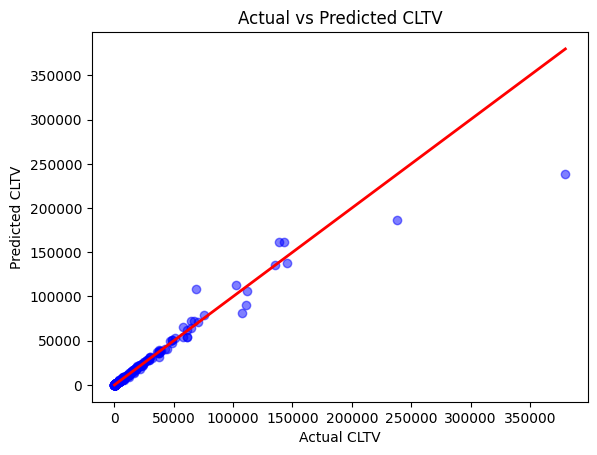

In [389]:
# Scatter plot of Actual vs Predicted CLTV
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', lw=2)  # Diagonal line
plt.xlabel('Actual CLTV')
plt.ylabel('Predicted CLTV')
plt.title('Actual vs Predicted CLTV')
plt.show()


Generally, we see that the predicted blue points follow the values of the red line, with a few cases of over and under prediction especially as the CLTV increases.